### And welcome to Week 4, Day 3 - more LangGraph..

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict


In [2]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

### First, let's go set up LangSmith!

https://langsmith.com

### Next, here is a useful function in LangChain community:

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("How much is 7.5 crores INR in USD")

'876,969.00 United States Dollar'

### Now here is a LangChain wrapper class for converting functions into Tools

In [4]:
from langchain.agents import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )



### Now we can try out the tool the langchain way

In [5]:
tool_search.invoke("How much is 7.5 crores INR in USD?")

'876,969.00 United States Dollar'

### And now let's write a tool ourselves

We'll pick a familiar one

In [6]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [7]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("Hello, me")

### Back to the Graph from yesterday

One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [8]:
tools = [tool_search, tool_push]

In [9]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [10]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [11]:
import os
google_api_key = os.getenv('GOOGLE_API_KEY')

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:2]}")
else:
    print("Google API Key not set (and this is optional)")

Google API Key exists and begins AI


In [12]:
# model_name = "gemini-2.0-flash"
# llm = ChatOpenAI(api_key=google_api_key, base_url="https://generativelanguage.googleapis.com/v1beta/openai/", model=model_name)

In [13]:
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI

model_name = "gemini-2.0-flash"
llm = ChatGoogleGenerativeAI(model = model_name, google_api_key = google_api_key)

In [14]:
# This is different:

# llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [15]:
# Step 3: Create a Node


def chatbot(state: State):
    messages = [llm_with_tools.invoke(state["messages"])]
    print(messages)
    return {"messages": messages}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [16]:
# Step 4: Create Edges


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

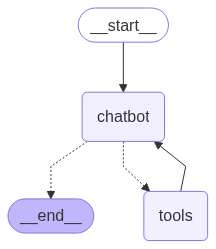

In [25]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [26]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    print(result)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='do u know my name?', additional_kwargs={}, response_metadata={}, id='e9f1e7f8-f76f-464c-a4c6-5600c8e5244d')]}
{'messages': [HumanMessage(content='do u know my name?', additional_kwargs={}, response_metadata={}, id='e9f1e7f8-f76f-464c-a4c6-5600c8e5244d'), AIMessage(content='I do not have access to personal information. I do not know your name.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--cf4e9a88-4ef7-4273-93ec-47b5e55815d5-0', usage_metadata={'input_tokens': 49, 'output_tokens': 17, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}})]}
{'messages': [HumanMessage(content='My name is Reema', additional_kwargs={}, response_metadata={}, id='8f5b8e32-3545-4560-8c4b-53b2311e7a85')]}
{'messages': [HumanMessage(content='My name is Reema', additional_kwargs={}, response_metadata={}, id='8f5b8e32-3545-4560-8c4b-53b2311e7a85'), AIMessa

## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [27]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

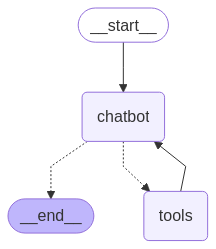

In [28]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
# llm = ChatOpenAI(model="gpt-4o-mini")
# llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Do u know my name?', additional_kwargs={}, response_metadata={}, id='8969c2c0-2856-4366-ae13-41d48937051b'), AIMessage(content='I do not have access to personal information. As a large language model, I respect your privacy.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--7a9993a4-13f2-4bb2-a6b5-d22c8c9f5cd0-0', usage_metadata={'input_tokens': 49, 'output_tokens': 21, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='My name is Reema', additional_kwargs={}, response_metadata={}, id='182caeb0-9d96-48f9-a892-1929f7b95c95'), AIMessage(content='Nice to meet you, Reema!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--e2b10413-b7c9-4b22-84a0-ea983e81b984-0', usage_metadata={'input_tokens': 74, 'ou

In [34]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Do u know my name?', additional_kwargs={}, response_metadata={}, id='8969c2c0-2856-4366-ae13-41d48937051b'), AIMessage(content='I do not have access to personal information. As a large language model, I respect your privacy.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--7a9993a4-13f2-4bb2-a6b5-d22c8c9f5cd0-0', usage_metadata={'input_tokens': 49, 'output_tokens': 21, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='My name is Reema', additional_kwargs={}, response_metadata={}, id='182caeb0-9d96-48f9-a892-1929f7b95c95'), AIMessage(content='Nice to meet you, Reema!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--e2b10413-b7c9-4b22-84a0-ea983e81b984-0', usage_metadata={'i

In [35]:
# Most recent first

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Do u know my name?', additional_kwargs={}, response_metadata={}, id='8969c2c0-2856-4366-ae13-41d48937051b'), AIMessage(content='I do not have access to personal information. As a large language model, I respect your privacy.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--7a9993a4-13f2-4bb2-a6b5-d22c8c9f5cd0-0', usage_metadata={'input_tokens': 49, 'output_tokens': 21, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='My name is Reema', additional_kwargs={}, response_metadata={}, id='182caeb0-9d96-48f9-a892-1929f7b95c95'), AIMessage(content='Nice to meet you, Reema!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--e2b10413-b7c9-4b22-84a0-ea983e81b984-0', usage_metadata={'

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [39]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

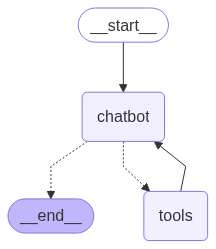

In [40]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
# llm = ChatOpenAI(model="gpt-4o-mini")
# llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [41]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi... do u know my name?', additional_kwargs={}, response_metadata={}, id='3e4fdfdd-4153-4f9c-be7e-863624499ba6')]}
{'messages': [HumanMessage(content='hi... do u know my name?', additional_kwargs={}, response_metadata={}, id='3e4fdfdd-4153-4f9c-be7e-863624499ba6'), AIMessage(content="I do not have access to personal information, so I don't know your name.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--165dc732-707b-4c4f-990a-68a58cc05516-0', usage_metadata={'input_tokens': 51, 'output_tokens': 19, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='My name is reema', additional_kwargs={}, response_metadata={}, id='31b4d9da-84bc-461e-9c7b-6f3efc6109df')]}
